# 1.30d: Freeze Transition Microstructure

**Purpose:** Characterize the dynamics of the mixed freeze/motion phase.

## Context

From 1.30c, we know:
- **First freeze:** Some token hits displacement=0 early in training
- **Last motion:** t=3291 (final lattice hop)
- **Permanent freeze:** t=3292 → t=6000 (2708 steps of absolute stillness)

**Question:** What happens in the **transition window** between first freeze and last motion?

Like a phase transition (liquid → solid), we expect:
- Mixed phase where some tokens freeze, some hop
- Possible trends: asymptotic cooling (hops get smaller) vs. chaotic jitter (constant amplitude)
- Nucleation-like dynamics: tokens freeze in clusters/bursts?

## Method

Focus on the **transition window** (roughly t=500-3300):
- **Displacement magnitudes:** L2 (Euclidean) and L∞ (Chebyshev) norms
- **Freeze rate:** Fraction of dead tokens moving at each timestep
- **Smoothed trends:** Rolling averages to expose underlying dynamics
- **Comparison to 8×ULP threshold:** Are hops staying near the lattice limit or cooling below it?

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Classification thresholds
DIAGONAL_FACTOR = 8  # sqrt(64) for hypercube diagonal

# Transition window (will be refined after loading data)
# We'll focus on t where at least one token is frozen but not all are frozen
WINDOW_START = 500  # Rough start (after thermal regime ends)
WINDOW_END = 3300   # Rough end (after last motion)

# Smoothing
ROLLING_WINDOW = 100  # Steps for rolling average

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
import pandas as pd  # For rolling window

print("✓ Imports complete")

✓ Imports complete


## Load Data (Vectorized)

In [3]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    # Load dead token trajectories
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} × {n_dead} × 64)")
    W_dead_bf16 = torch.from_numpy(f['W'][:, dead_mask, :]).to(torch.bfloat16)
    W_dead = W_dead_bf16.float()

print(f"\n✓ Data loaded: {tuple(W_dead.shape)}")

Loading dead token trajectories from ../tensors/Thimble/thimble_6.h5...

Loading W[:, dead_mask, :] ... (6001 × 3699 × 64)

✓ Data loaded: (6001, 3699, 64)


## Compute Displacements and ULP (Vectorized)

In [4]:
print("Computing displacements and ULP (vectorized)...\n")

# Displacement vectors: W[t+1] - W[t]
dW = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64)

# L2 norm (Euclidean)
displacement_L2 = torch.norm(dW, dim=2)  # (6000, 3699)

# L-infinity norm (Chebyshev - max coordinate change)
displacement_Linf = dW.abs().max(dim=2)[0]  # (6000, 3699)

# ULP
def compute_ulp_matrix(W_bf16):
    inf_tensor = torch.tensor(float('inf'), dtype=torch.bfloat16, device=W_bf16.device)
    next_up = torch.nextafter(W_bf16, inf_tensor)
    ulp = (next_up - W_bf16).abs().float()
    return ulp

ulp_all = compute_ulp_matrix(W_dead_bf16[:-1])  # (6000, 3699, 64)
mean_ulp_per_token = ulp_all.mean(dim=2)  # (6000, 3699)
lattice_threshold = DIAGONAL_FACTOR * mean_ulp_per_token  # (6000, 3699)

print(f"Displacement L2:   {tuple(displacement_L2.shape)}")
print(f"Displacement L∞:   {tuple(displacement_Linf.shape)}")
print(f"Lattice threshold: {tuple(lattice_threshold.shape)}")
print(f"\n✓ Displacements computed")

Computing displacements and ULP (vectorized)...

Displacement L2:   (6000, 3699)
Displacement L∞:   (6000, 3699)
Lattice threshold: (6000, 3699)

✓ Displacements computed


## Identify Transition Window

In [5]:
print("Identifying exact transition window...\n")

# Moving: displacement > 0
moving = (displacement_L2 > 0)  # (6000, 3699)
fraction_moving = moving.float().mean(dim=1)  # (6000,)

# Find first timestep where at least one token is frozen
any_frozen = (~moving).any(dim=1)  # (6000,)
first_freeze_step = any_frozen.nonzero()[0].item() if any_frozen.any() else 0

# Find last timestep where at least one token moved
any_moving = moving.any(dim=1)  # (6000,)
last_motion_step = any_moving.nonzero()[-1].item() if any_moving.any() else len(moving)-1

print(f"First freeze (at least one token frozen): t={first_freeze_step}")
print(f"Last motion (at least one token moved):   t={last_motion_step}")
print(f"Transition window duration:               {last_motion_step - first_freeze_step + 1} steps")
print(f"\nUsing window: t={first_freeze_step} → t={last_motion_step}")

# Update window bounds
WINDOW_START = first_freeze_step
WINDOW_END = last_motion_step + 1  # Inclusive

print(f"\n✓ Transition window identified")

Identifying exact transition window...

First freeze (at least one token frozen): t=220
Last motion (at least one token moved):   t=3291
Transition window duration:               3072 steps

Using window: t=220 → t=3291

✓ Transition window identified


## Compute Per-Timestep Statistics (Moving Tokens Only)

In [6]:
print("Computing statistics for moving tokens...\n")

n_steps = len(displacement_L2)

# Preallocate
mean_L2_movers = torch.zeros(n_steps)
median_L2_movers = torch.zeros(n_steps)
p90_L2_movers = torch.zeros(n_steps)
mean_Linf_movers = torch.zeros(n_steps)
mean_threshold_movers = torch.zeros(n_steps)
ratio_L2_Linf = torch.zeros(n_steps)  # How "diagonal" are the hops?

for t in range(n_steps):
    moving_t = moving[t]
    
    if moving_t.any():
        L2_moving = displacement_L2[t, moving_t]
        Linf_moving = displacement_Linf[t, moving_t]
        threshold_moving = lattice_threshold[t, moving_t]
        
        mean_L2_movers[t] = L2_moving.mean()
        median_L2_movers[t] = L2_moving.median()
        p90_L2_movers[t] = L2_moving.quantile(0.9)
        mean_Linf_movers[t] = Linf_moving.mean()
        mean_threshold_movers[t] = threshold_moving.mean()
        
        # Ratio: L2 / L∞ tells us if hops are axis-aligned (→1) or diagonal (→√64≈8)
        ratio_L2_Linf[t] = (L2_moving / Linf_moving).mean()
    else:
        # All frozen - set to NaN so they don't plot
        mean_L2_movers[t] = float('nan')
        median_L2_movers[t] = float('nan')
        p90_L2_movers[t] = float('nan')
        mean_Linf_movers[t] = float('nan')
        mean_threshold_movers[t] = float('nan')
        ratio_L2_Linf[t] = float('nan')

print(f"✓ Statistics computed for {n_steps} timesteps")

Computing statistics for moving tokens...

✓ Statistics computed for 6000 timesteps


## Apply Smoothing (Rolling Average)

In [7]:
print(f"Applying rolling average (window={ROLLING_WINDOW})...\n")

def rolling_mean(x, window):
    """Compute rolling mean, ignoring NaNs."""
    return pd.Series(x.numpy()).rolling(window, center=True, min_periods=1).mean().values

# Smooth the statistics
mean_L2_smooth = torch.from_numpy(rolling_mean(mean_L2_movers, ROLLING_WINDOW))
median_L2_smooth = torch.from_numpy(rolling_mean(median_L2_movers, ROLLING_WINDOW))
p90_L2_smooth = torch.from_numpy(rolling_mean(p90_L2_movers, ROLLING_WINDOW))
mean_Linf_smooth = torch.from_numpy(rolling_mean(mean_Linf_movers, ROLLING_WINDOW))
fraction_moving_smooth = torch.from_numpy(rolling_mean(fraction_moving, ROLLING_WINDOW))
ratio_smooth = torch.from_numpy(rolling_mean(ratio_L2_Linf, ROLLING_WINDOW))

print(f"✓ Smoothing applied")

Applying rolling average (window=100)...

✓ Smoothing applied


## Plot 1: Displacement Magnitudes (L2) with Smoothing

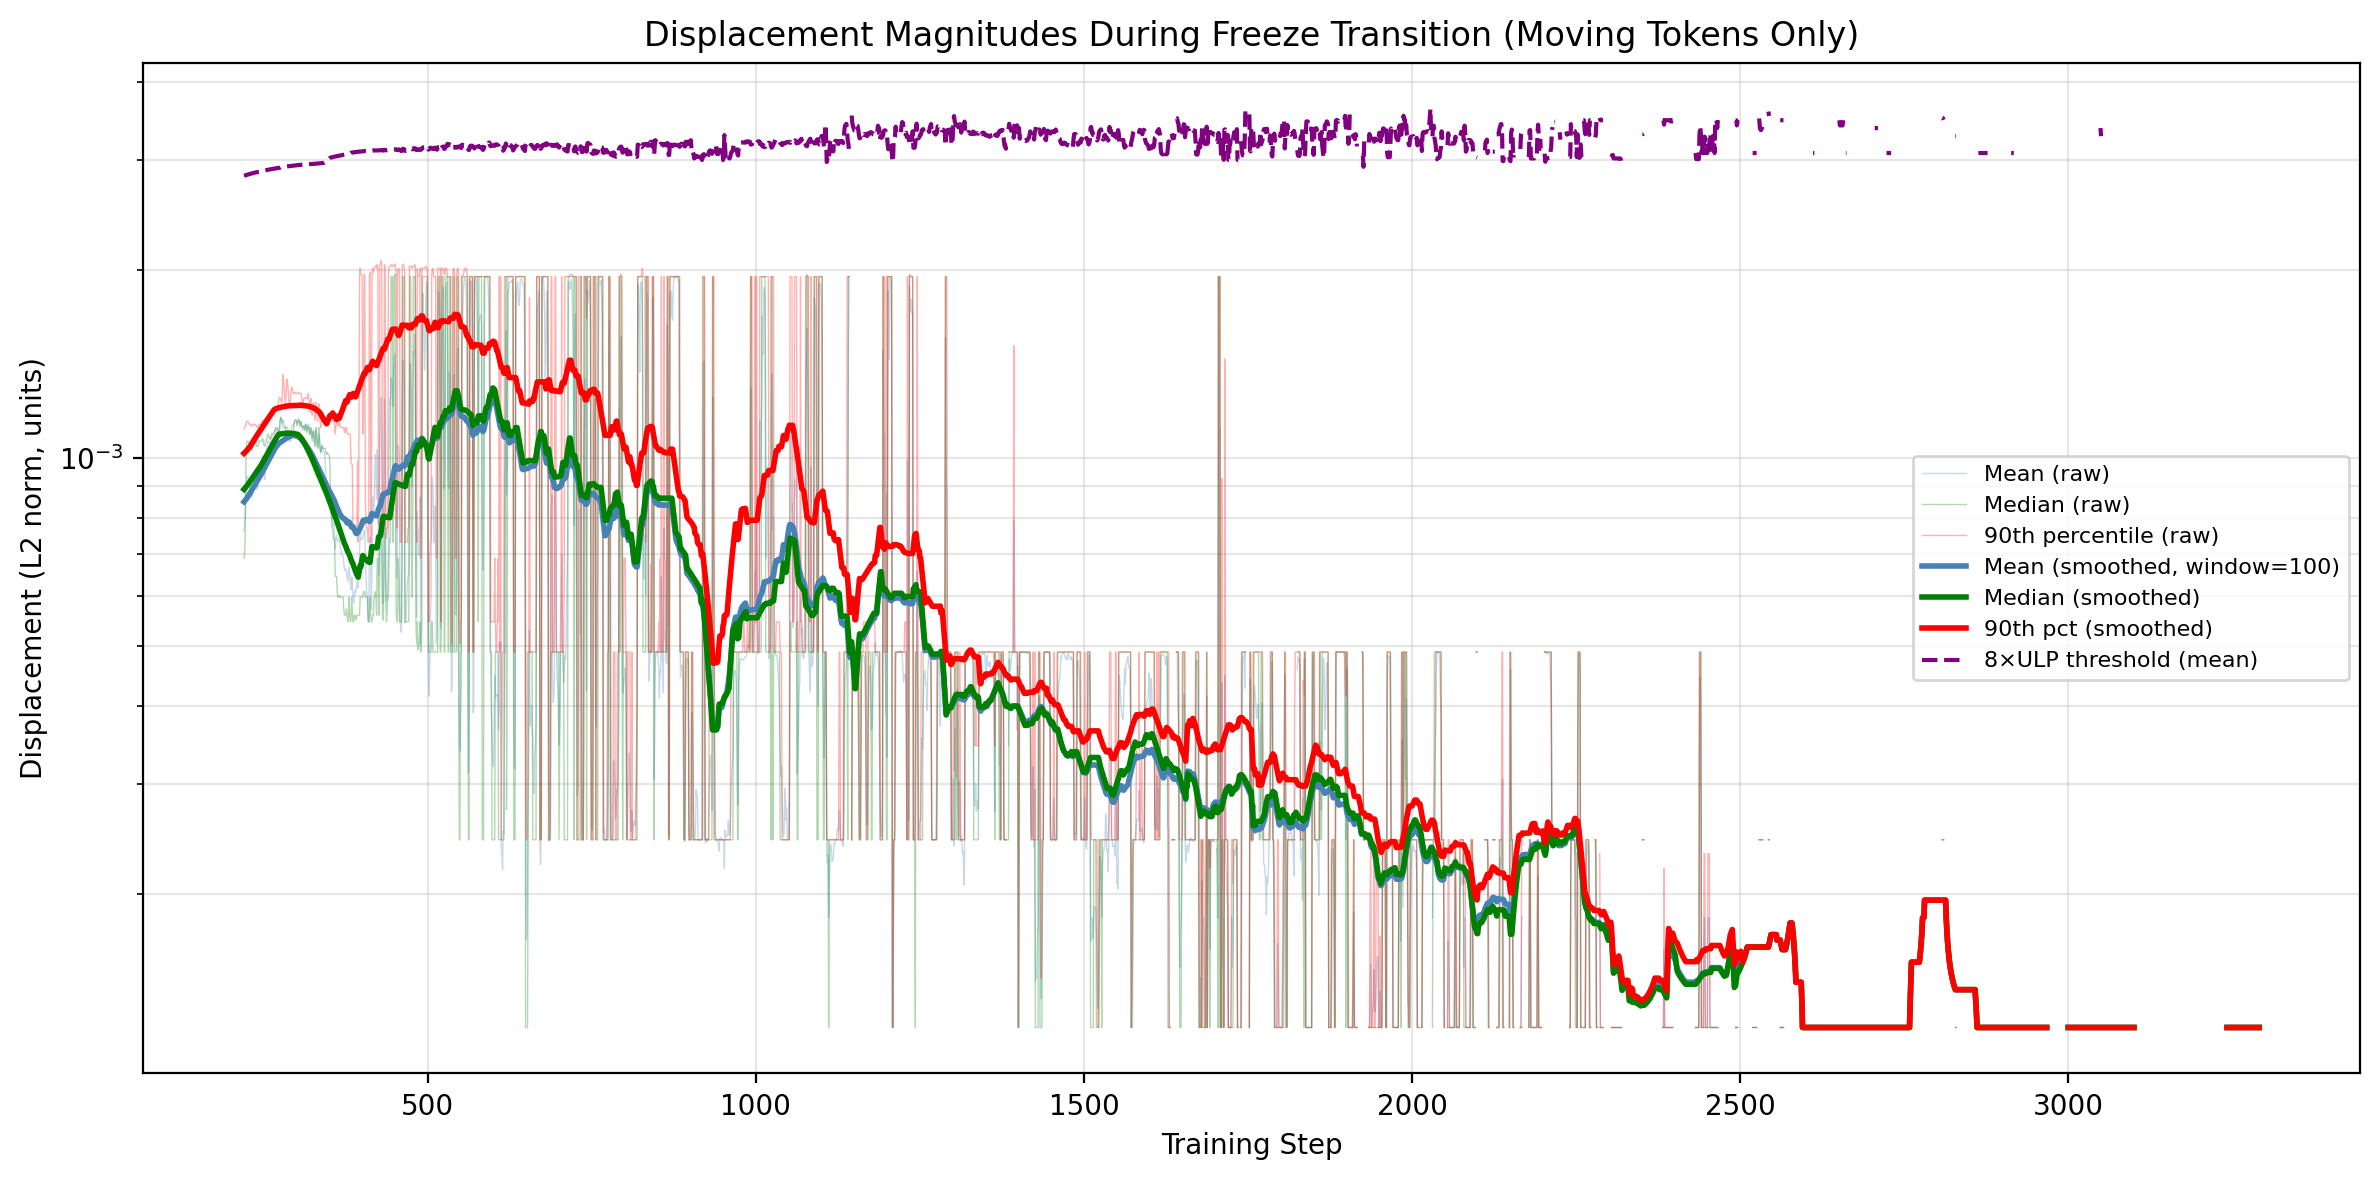


Interpretation:
  - If displacement decreases over time: asymptotic cooling (hops get smaller)
  - If displacement stays near 8×ULP: chaotic lattice jitter (constant amplitude)
  - If displacement increases: possible nucleation artifacts


In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Focus on transition window
window = slice(WINDOW_START, WINDOW_END)
x = range(WINDOW_START, WINDOW_END)

# Raw data (semi-transparent)
ax.plot(x, mean_L2_movers[window].numpy(), color='steelblue', alpha=0.3, linewidth=0.5, label='Mean (raw)')
ax.plot(x, median_L2_movers[window].numpy(), color='green', alpha=0.3, linewidth=0.5, label='Median (raw)')
ax.plot(x, p90_L2_movers[window].numpy(), color='red', alpha=0.3, linewidth=0.5, label='90th percentile (raw)')

# Smoothed trends (solid)
ax.plot(x, mean_L2_smooth[window].numpy(), color='steelblue', linewidth=2, label=f'Mean (smoothed, window={ROLLING_WINDOW})')
ax.plot(x, median_L2_smooth[window].numpy(), color='green', linewidth=2, label=f'Median (smoothed)')
ax.plot(x, p90_L2_smooth[window].numpy(), color='red', linewidth=2, label=f'90th pct (smoothed)')

# Reference: 8×ULP threshold (mean)
ax.plot(x, mean_threshold_movers[window].numpy(), color='purple', linestyle='--', linewidth=1.5, label='8×ULP threshold (mean)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement (L2 norm, units)')
ax.set_title('Displacement Magnitudes During Freeze Transition (Moving Tokens Only)')
ax.set_yscale('log')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - If displacement decreases over time: asymptotic cooling (hops get smaller)")
print("  - If displacement stays near 8×ULP: chaotic lattice jitter (constant amplitude)")
print("  - If displacement increases: possible nucleation artifacts")

## Plot 2: Fraction of Tokens Moving Over Time

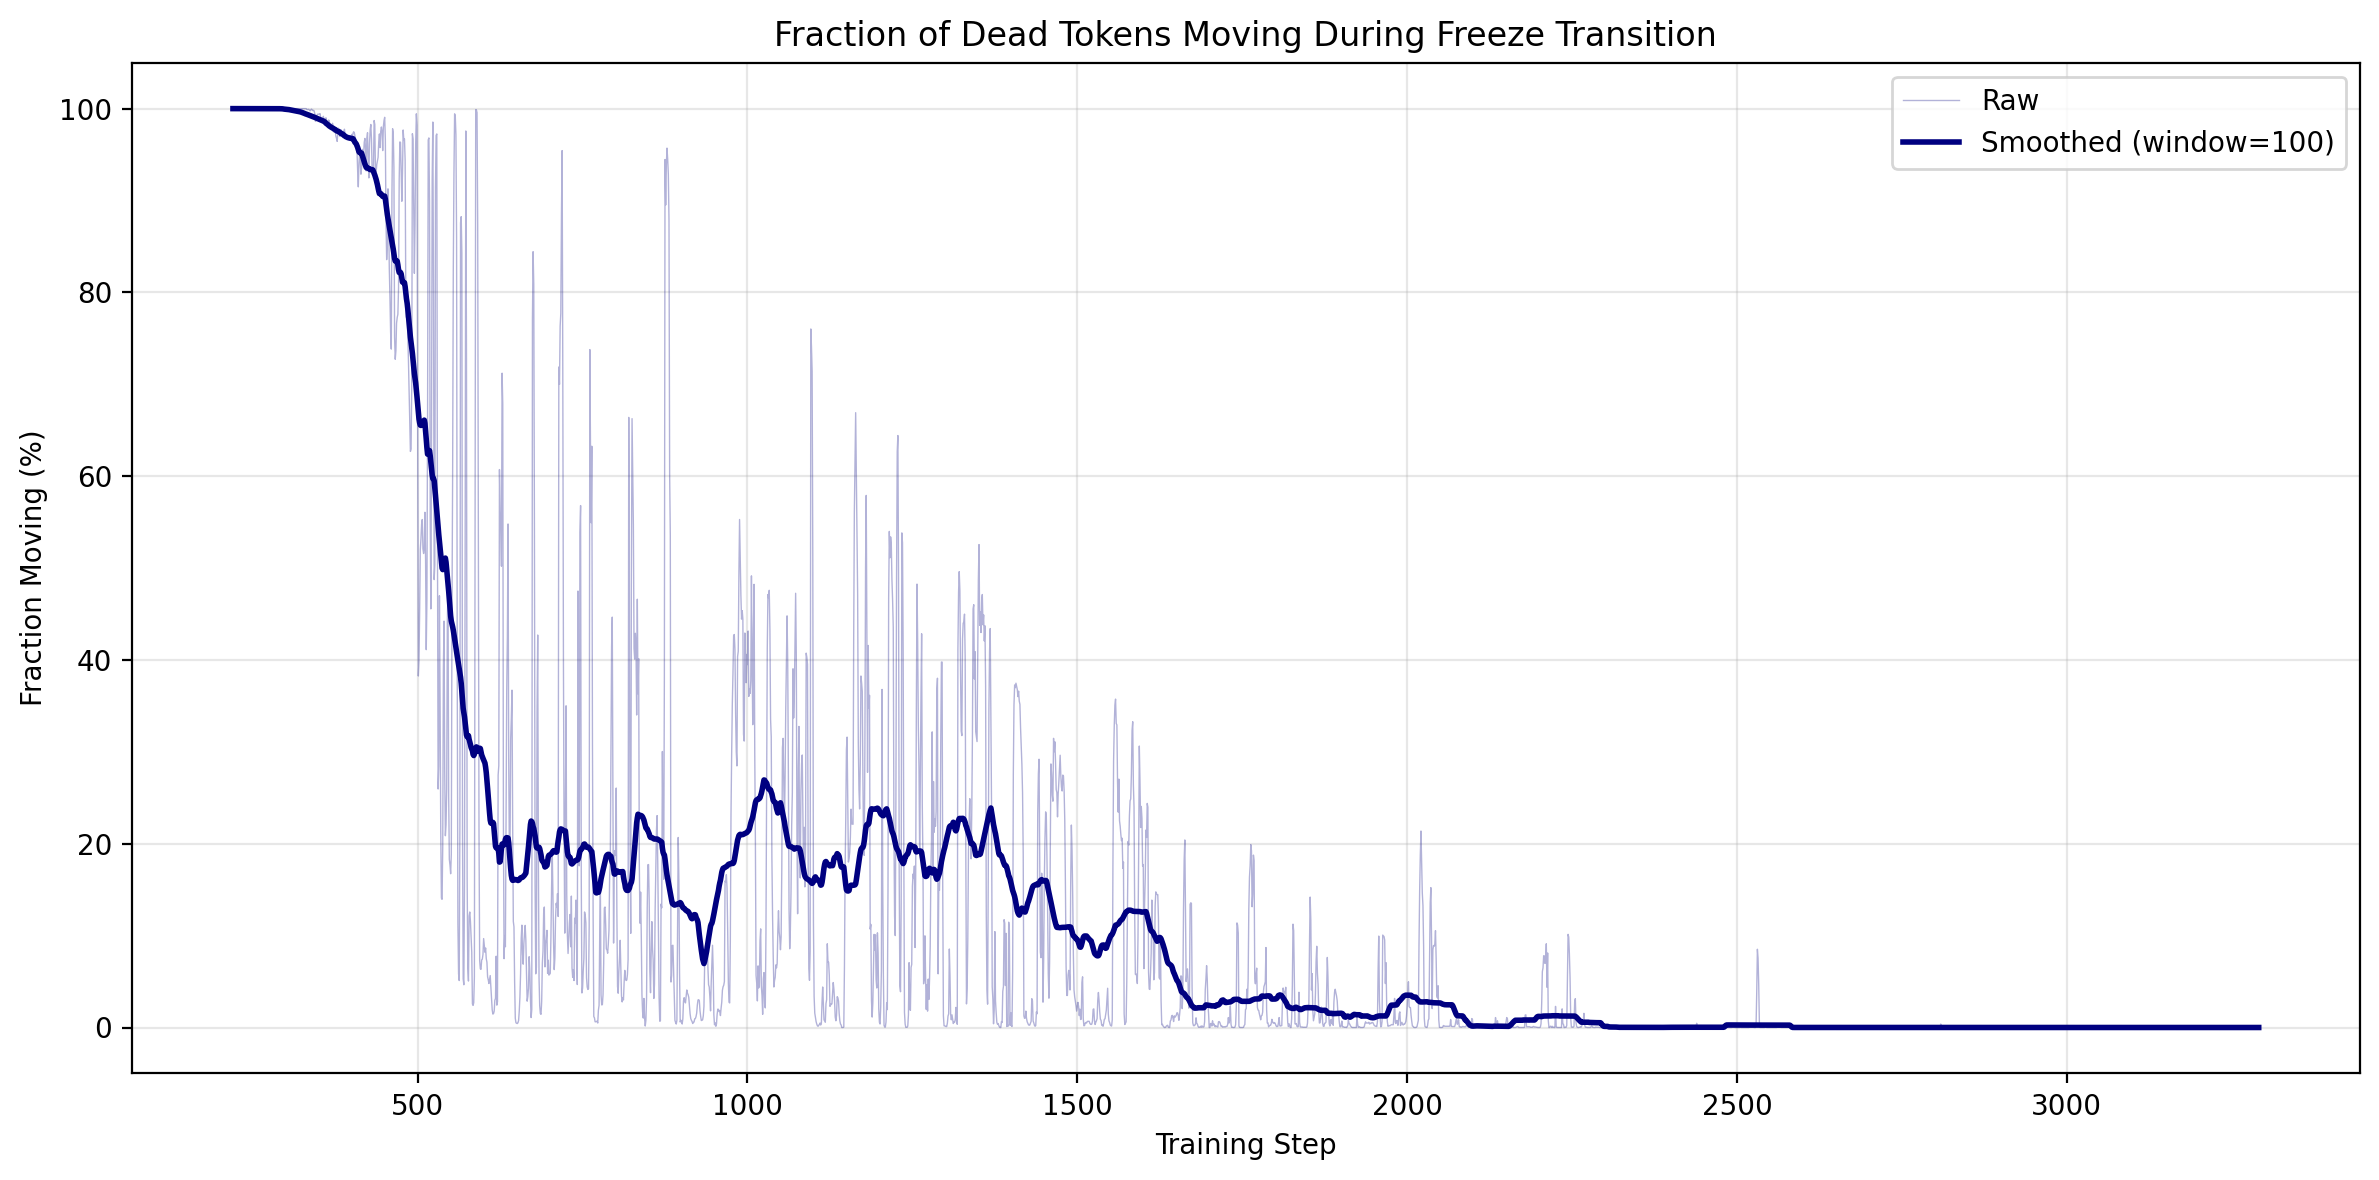


Interpretation:
  - Smooth decay: gradual freeze (like cooling below critical temperature)
  - Chaotic oscillation: tokens freeze/unfreeze unpredictably
  - Stepwise drops: nucleation-like (clusters freeze together)


In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Raw and smoothed
ax.plot(x, fraction_moving[window].numpy() * 100, color='navy', alpha=0.3, linewidth=0.5, label='Raw')
ax.plot(x, fraction_moving_smooth[window].numpy() * 100, color='navy', linewidth=2, label=f'Smoothed (window={ROLLING_WINDOW})')

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction Moving (%)')
ax.set_title('Fraction of Dead Tokens Moving During Freeze Transition')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Smooth decay: gradual freeze (like cooling below critical temperature)")
print("  - Chaotic oscillation: tokens freeze/unfreeze unpredictably")
print("  - Stepwise drops: nucleation-like (clusters freeze together)")

## Plot 3: L2 vs L∞ Ratio (Hop Geometry)

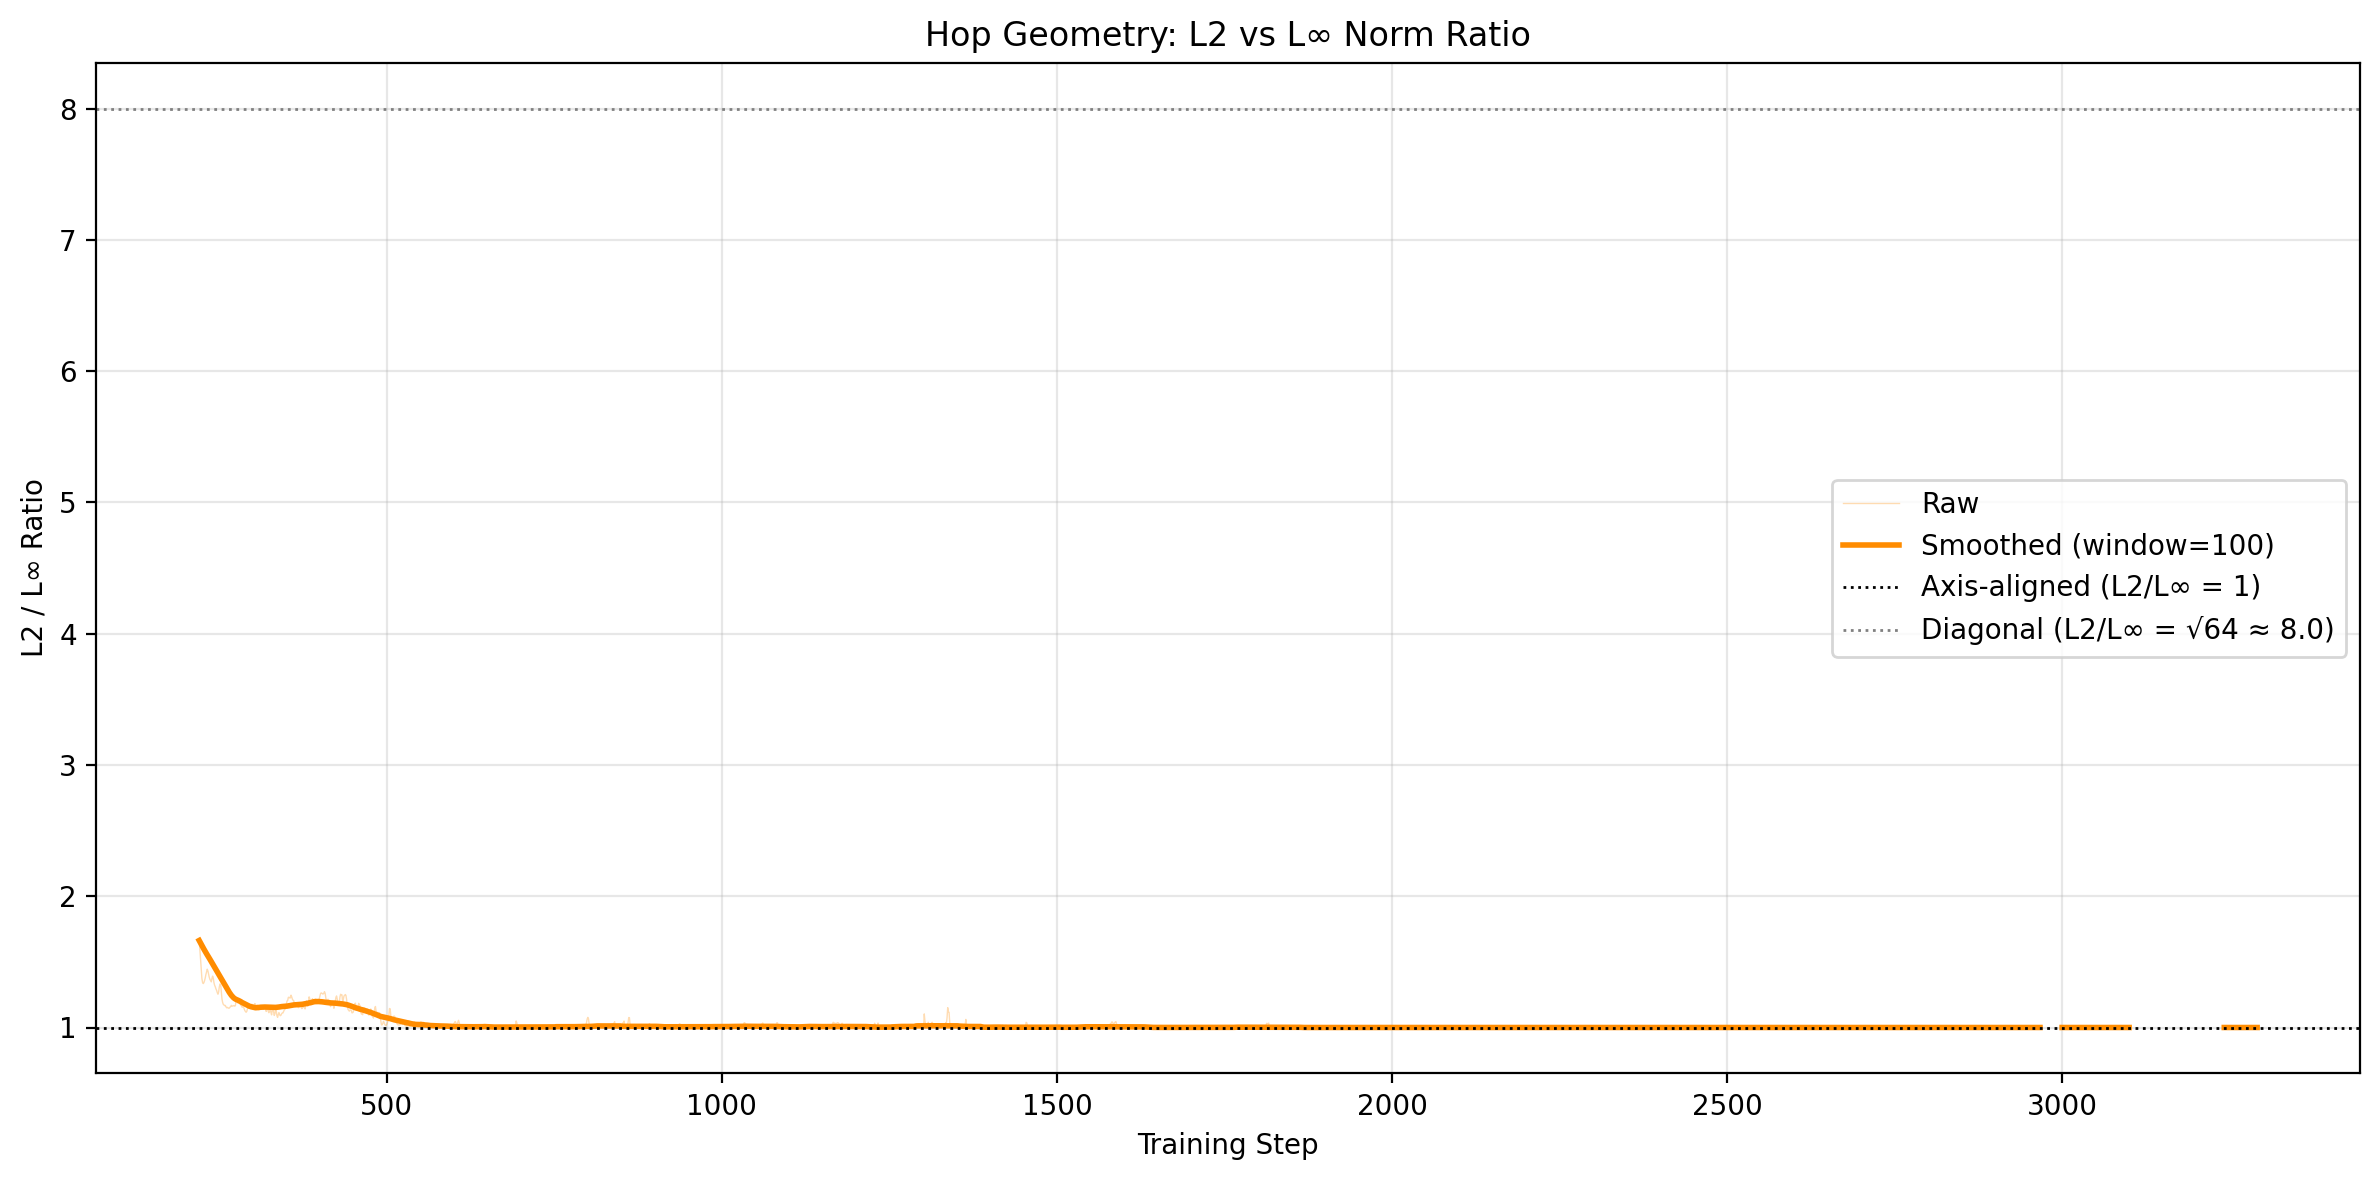


Interpretation:
  - Ratio ≈ 1: Hops are axis-aligned (change in single dimension)
  - Ratio ≈ √64 ≈ 8: Hops are diagonal (change spread across all dimensions)
  - Trend over time: Does hop geometry change as system freezes?


In [10]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Raw and smoothed
ax.plot(x, ratio_L2_Linf[window].numpy(), color='darkorange', alpha=0.3, linewidth=0.5, label='Raw')
ax.plot(x, ratio_smooth[window].numpy(), color='darkorange', linewidth=2, label=f'Smoothed (window={ROLLING_WINDOW})')

# Reference lines
ax.axhline(1.0, color='black', linestyle=':', linewidth=1, label='Axis-aligned (L2/L∞ = 1)')
ax.axhline(np.sqrt(64), color='gray', linestyle=':', linewidth=1, label=f'Diagonal (L2/L∞ = √64 ≈ {np.sqrt(64):.1f})')

ax.set_xlabel('Training Step')
ax.set_ylabel('L2 / L∞ Ratio')
ax.set_title('Hop Geometry: L2 vs L∞ Norm Ratio')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Ratio ≈ 1: Hops are axis-aligned (change in single dimension)")
print("  - Ratio ≈ √64 ≈ 8: Hops are diagonal (change spread across all dimensions)")
print("  - Trend over time: Does hop geometry change as system freezes?")

## Plot 4: Chebyshev (L∞) Displacement

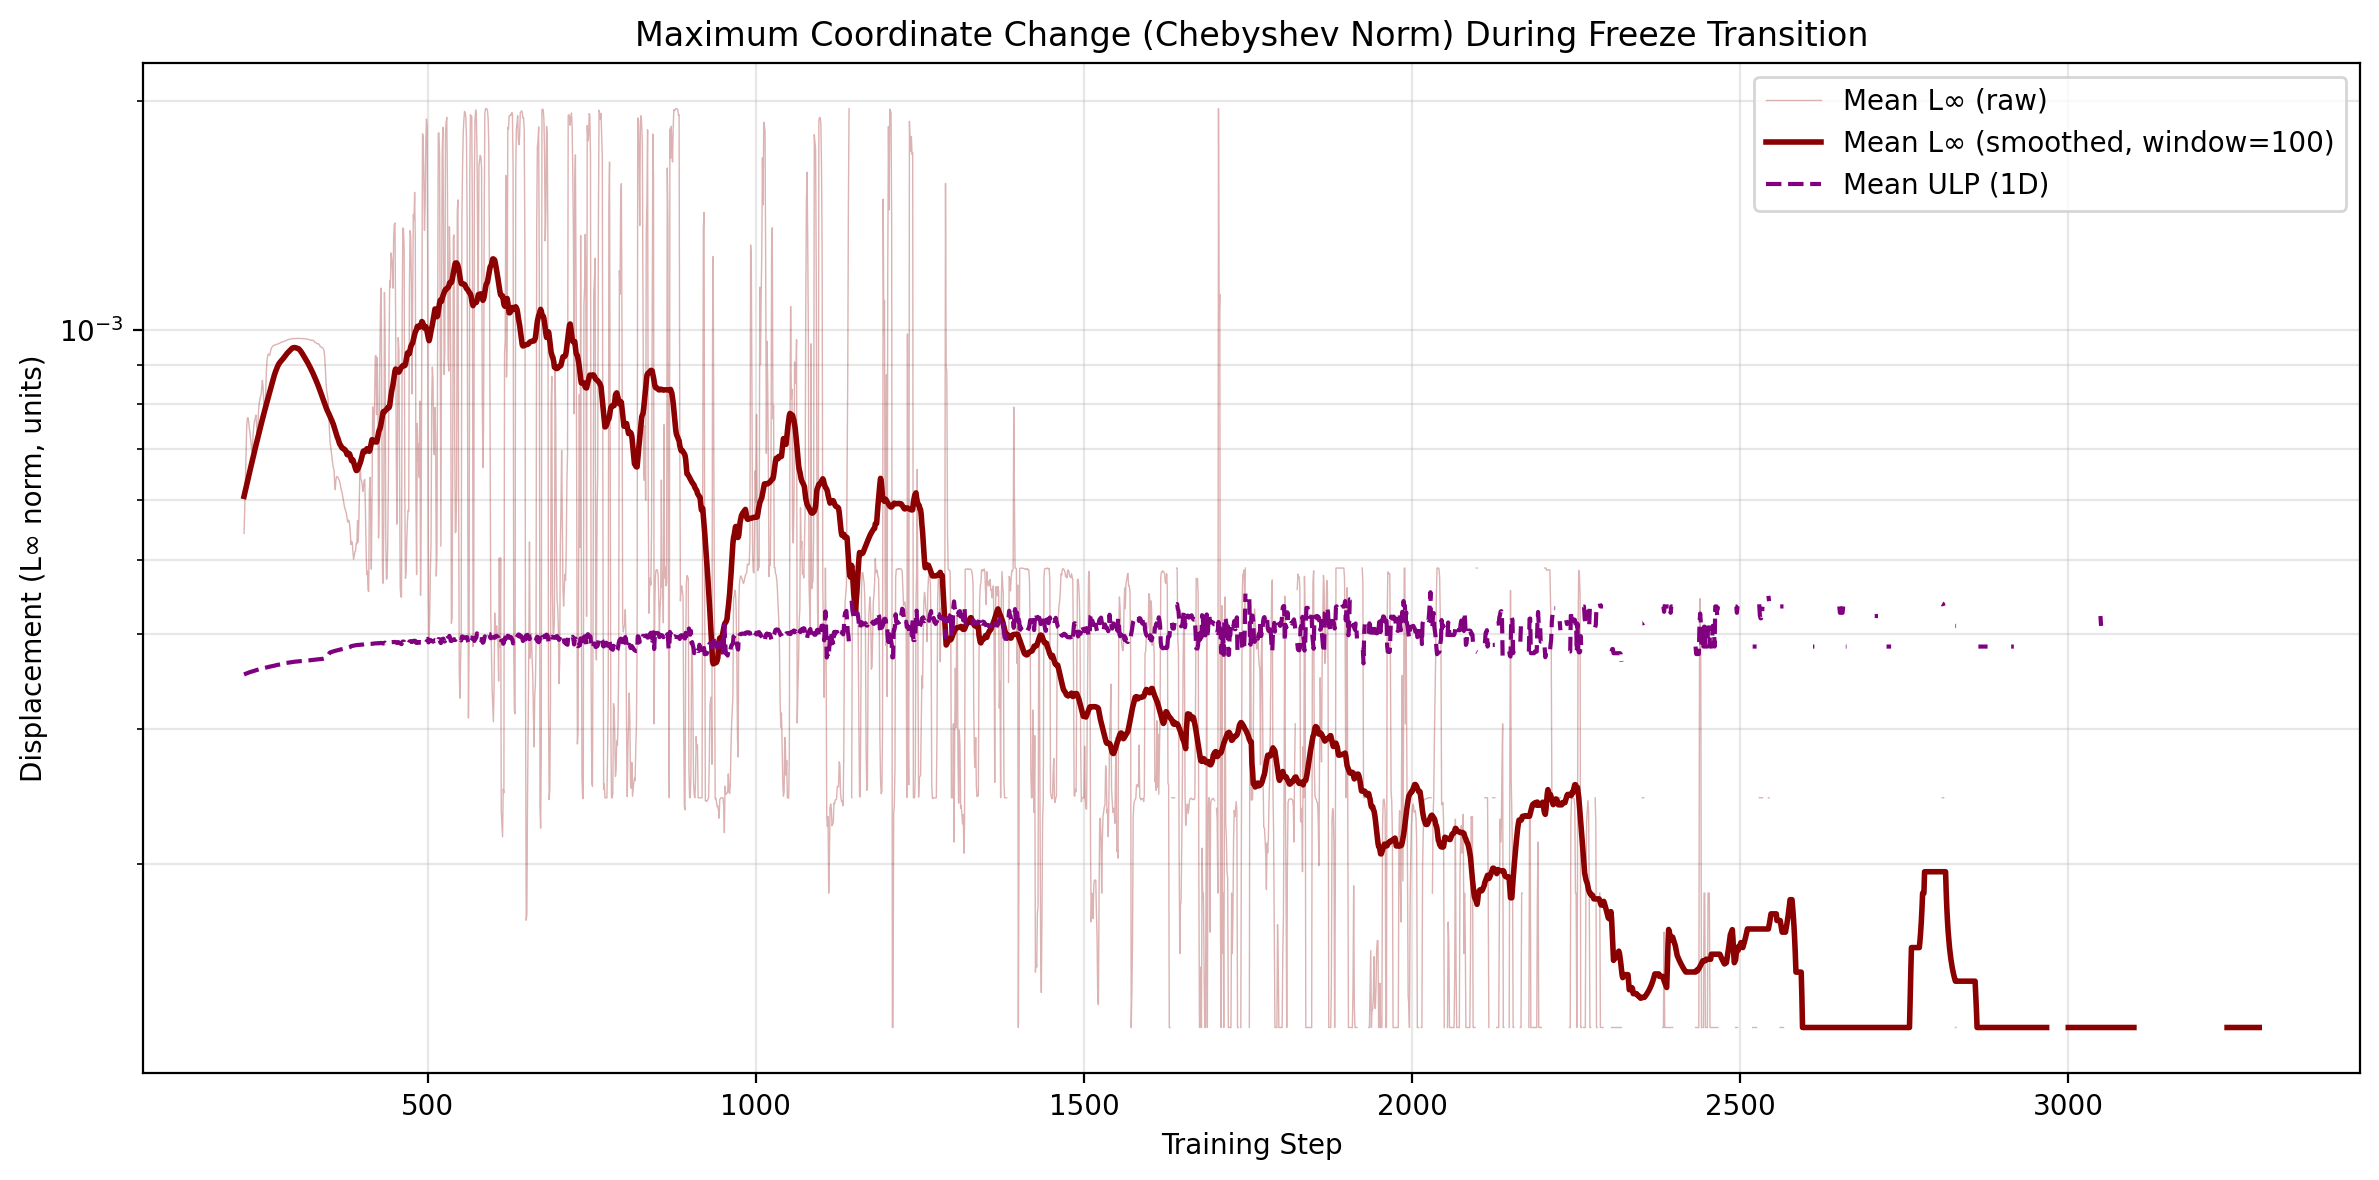


Interpretation:
  - L∞ shows largest single-coordinate change
  - Compare to 1D ULP: are hops quantized to single ULP steps in individual dimensions?


In [11]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Raw and smoothed
ax.plot(x, mean_Linf_movers[window].numpy(), color='darkred', alpha=0.3, linewidth=0.5, label='Mean L∞ (raw)')
ax.plot(x, mean_Linf_smooth[window].numpy(), color='darkred', linewidth=2, label=f'Mean L∞ (smoothed, window={ROLLING_WINDOW})')

# Reference: mean ULP (single dimension)
mean_ulp_1d = mean_threshold_movers[window] / DIAGONAL_FACTOR
ax.plot(x, mean_ulp_1d.numpy(), color='purple', linestyle='--', linewidth=1.5, label='Mean ULP (1D)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Displacement (L∞ norm, units)')
ax.set_title('Maximum Coordinate Change (Chebyshev Norm) During Freeze Transition')
ax.set_yscale('log')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - L∞ shows largest single-coordinate change")
print("  - Compare to 1D ULP: are hops quantized to single ULP steps in individual dimensions?")

## Summary Statistics

In [12]:
print("\n" + "="*80)
print("FREEZE TRANSITION MICROSTRUCTURE SUMMARY")
print("="*80 + "\n")

print(f"Transition window: t={WINDOW_START} → t={WINDOW_END-1} ({WINDOW_END - WINDOW_START} steps)\n")

# Split window into thirds to see evolution
third = (WINDOW_END - WINDOW_START) // 3
early = slice(WINDOW_START, WINDOW_START + third)
mid = slice(WINDOW_START + third, WINDOW_START + 2*third)
late = slice(WINDOW_START + 2*third, WINDOW_END)

print("Displacement evolution (mean L2, moving tokens only):")
print(f"  Early third:  {mean_L2_smooth[early].nanmean():.4e} units")
print(f"  Middle third: {mean_L2_smooth[mid].nanmean():.4e} units")
print(f"  Late third:   {mean_L2_smooth[late].nanmean():.4e} units")

early_mean = mean_L2_smooth[early].nanmean()
late_mean = mean_L2_smooth[late].nanmean()
if not torch.isnan(early_mean) and not torch.isnan(late_mean):
    change = (late_mean - early_mean) / early_mean * 100
    print(f"  Change: {change:+.1f}%")
print()

print("Fraction moving evolution:")
print(f"  Early third:  {fraction_moving_smooth[early].mean():.1%}")
print(f"  Middle third: {fraction_moving_smooth[mid].mean():.1%}")
print(f"  Late third:   {fraction_moving_smooth[late].mean():.1%}")
print()

print("Hop geometry (L2/L∞ ratio):")
print(f"  Mean: {ratio_smooth[window].nanmean():.2f}")
print(f"  (1.0 = axis-aligned, {np.sqrt(64):.1f} = fully diagonal)")
print()

# Compare displacement to threshold
valid = ~torch.isnan(mean_L2_smooth[window]) & ~torch.isnan(mean_threshold_movers[window])
if valid.any():
    ratio_to_threshold = (mean_L2_smooth[window][valid] / mean_threshold_movers[window][valid]).mean()
    print(f"Mean displacement / 8×ULP threshold: {ratio_to_threshold:.2f}")
    if ratio_to_threshold < 0.8:
        print("  → Hops are cooling below lattice limit")
    elif ratio_to_threshold > 1.2:
        print("  → Hops exceed lattice limit (unexpected!)")
    else:
        print("  → Hops hover near lattice limit (chaotic jitter)")

print("\n" + "="*80)
print("✓ Freeze transition microstructure analysis complete.")
print("="*80)


FREEZE TRANSITION MICROSTRUCTURE SUMMARY

Transition window: t=220 → t=3291 (3072 steps)

Displacement evolution (mean L2, moving tokens only):
  Early third:  8.2252e-04 units
  Middle third: 2.9697e-04 units
  Late third:   1.3979e-04 units
  Change: -83.0%

Fraction moving evolution:
  Early third:  42.3%
  Middle third: 6.9%
  Late third:   0.0%

Hop geometry (L2/L∞ ratio):
  Mean: 1.02
  (1.0 = axis-aligned, 8.0 = fully diagonal)

Mean displacement / 8×ULP threshold: 0.17
  → Hops are cooling below lattice limit

✓ Freeze transition microstructure analysis complete.
